In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'alzheimers-dataset-4-class-of-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F457093%2F861496%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T101426Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6e7529ef3d2d2e0f3d5070829976be8ac4d2aa8e44c5449879d74926fdda859273d7fb126a5dcf51c087f8cec22d3ff380b4eb0b23680951911ea6029f5b307d14149caa0988c0b6823f174243360807dbb2abd58b5cfc19abb933e192577192c3b34456528e56b479f97ba6e404ca59444aa4ddcf0ec23d102935c4c3ab23ec7f95cd169b46722627659df002d8f2c653f5310028e15ce412180373e8a2158da0193a8c44be0b64b55cf50b7e69115ad52d2b5befadbfe91c9918cbc84965e1925c5fed9c61b3a3cc0faf2e7950d358d3b011ef00a0cf01e714a2367c971f1b2fb9be0ebb075b8bbc41083047afecd34074711e208cf94d5b8d97c12bdf6ed1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 35779075 bytes downloaded
Downloaded and uncompressed: alzheimers-dataset-4-class-of-images
Data source import complete.


# <p><center style="font-family:newtimeroman;font-size:180%;">Выявление и оценка болезни Альцгеймера с помощью анализа изображений сетью InceptionV3</center></p>
### Содержание:

* [Импорт библиотек](#1)
* [Загрузка данных](#2)
* [Визуализация набора данных](#3)
* [Исследование данных](#4)
* [InceptionV3 Модель](#10)
* [Оценка модели](#11)


**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Импорт библиотек </p>
<a class="btn" href="#home">Содержание</a>

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

**<a id="2"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Загрузка данных</p>
<a class="btn" href="#home">Содержание</a>

In [ ]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset')):
    subfolder_path = os.path.join('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00, 89.50it/s]


image             label
0     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
1     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
2     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
3     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
4     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
...                                                 ...               ...
6395  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
6396  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
6397  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
6398  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
6399  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented

[6400 rows x 2 columns]

**<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Визуализация данных</p>
<a class="btn" href="#home">Содержание</a>

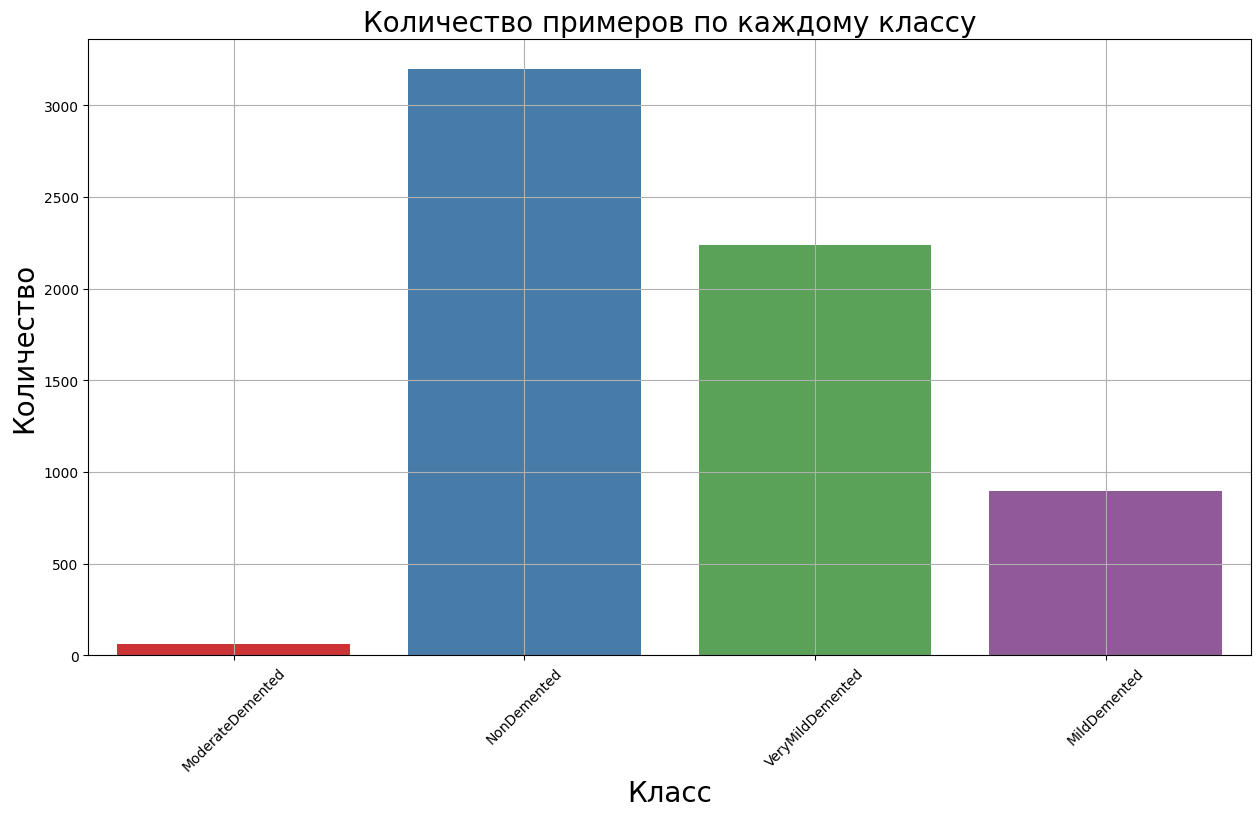

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Класс",fontsize=20)
ax.set_ylabel("Количество",fontsize=20)
plt.title('Количество примеров по каждому классу',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

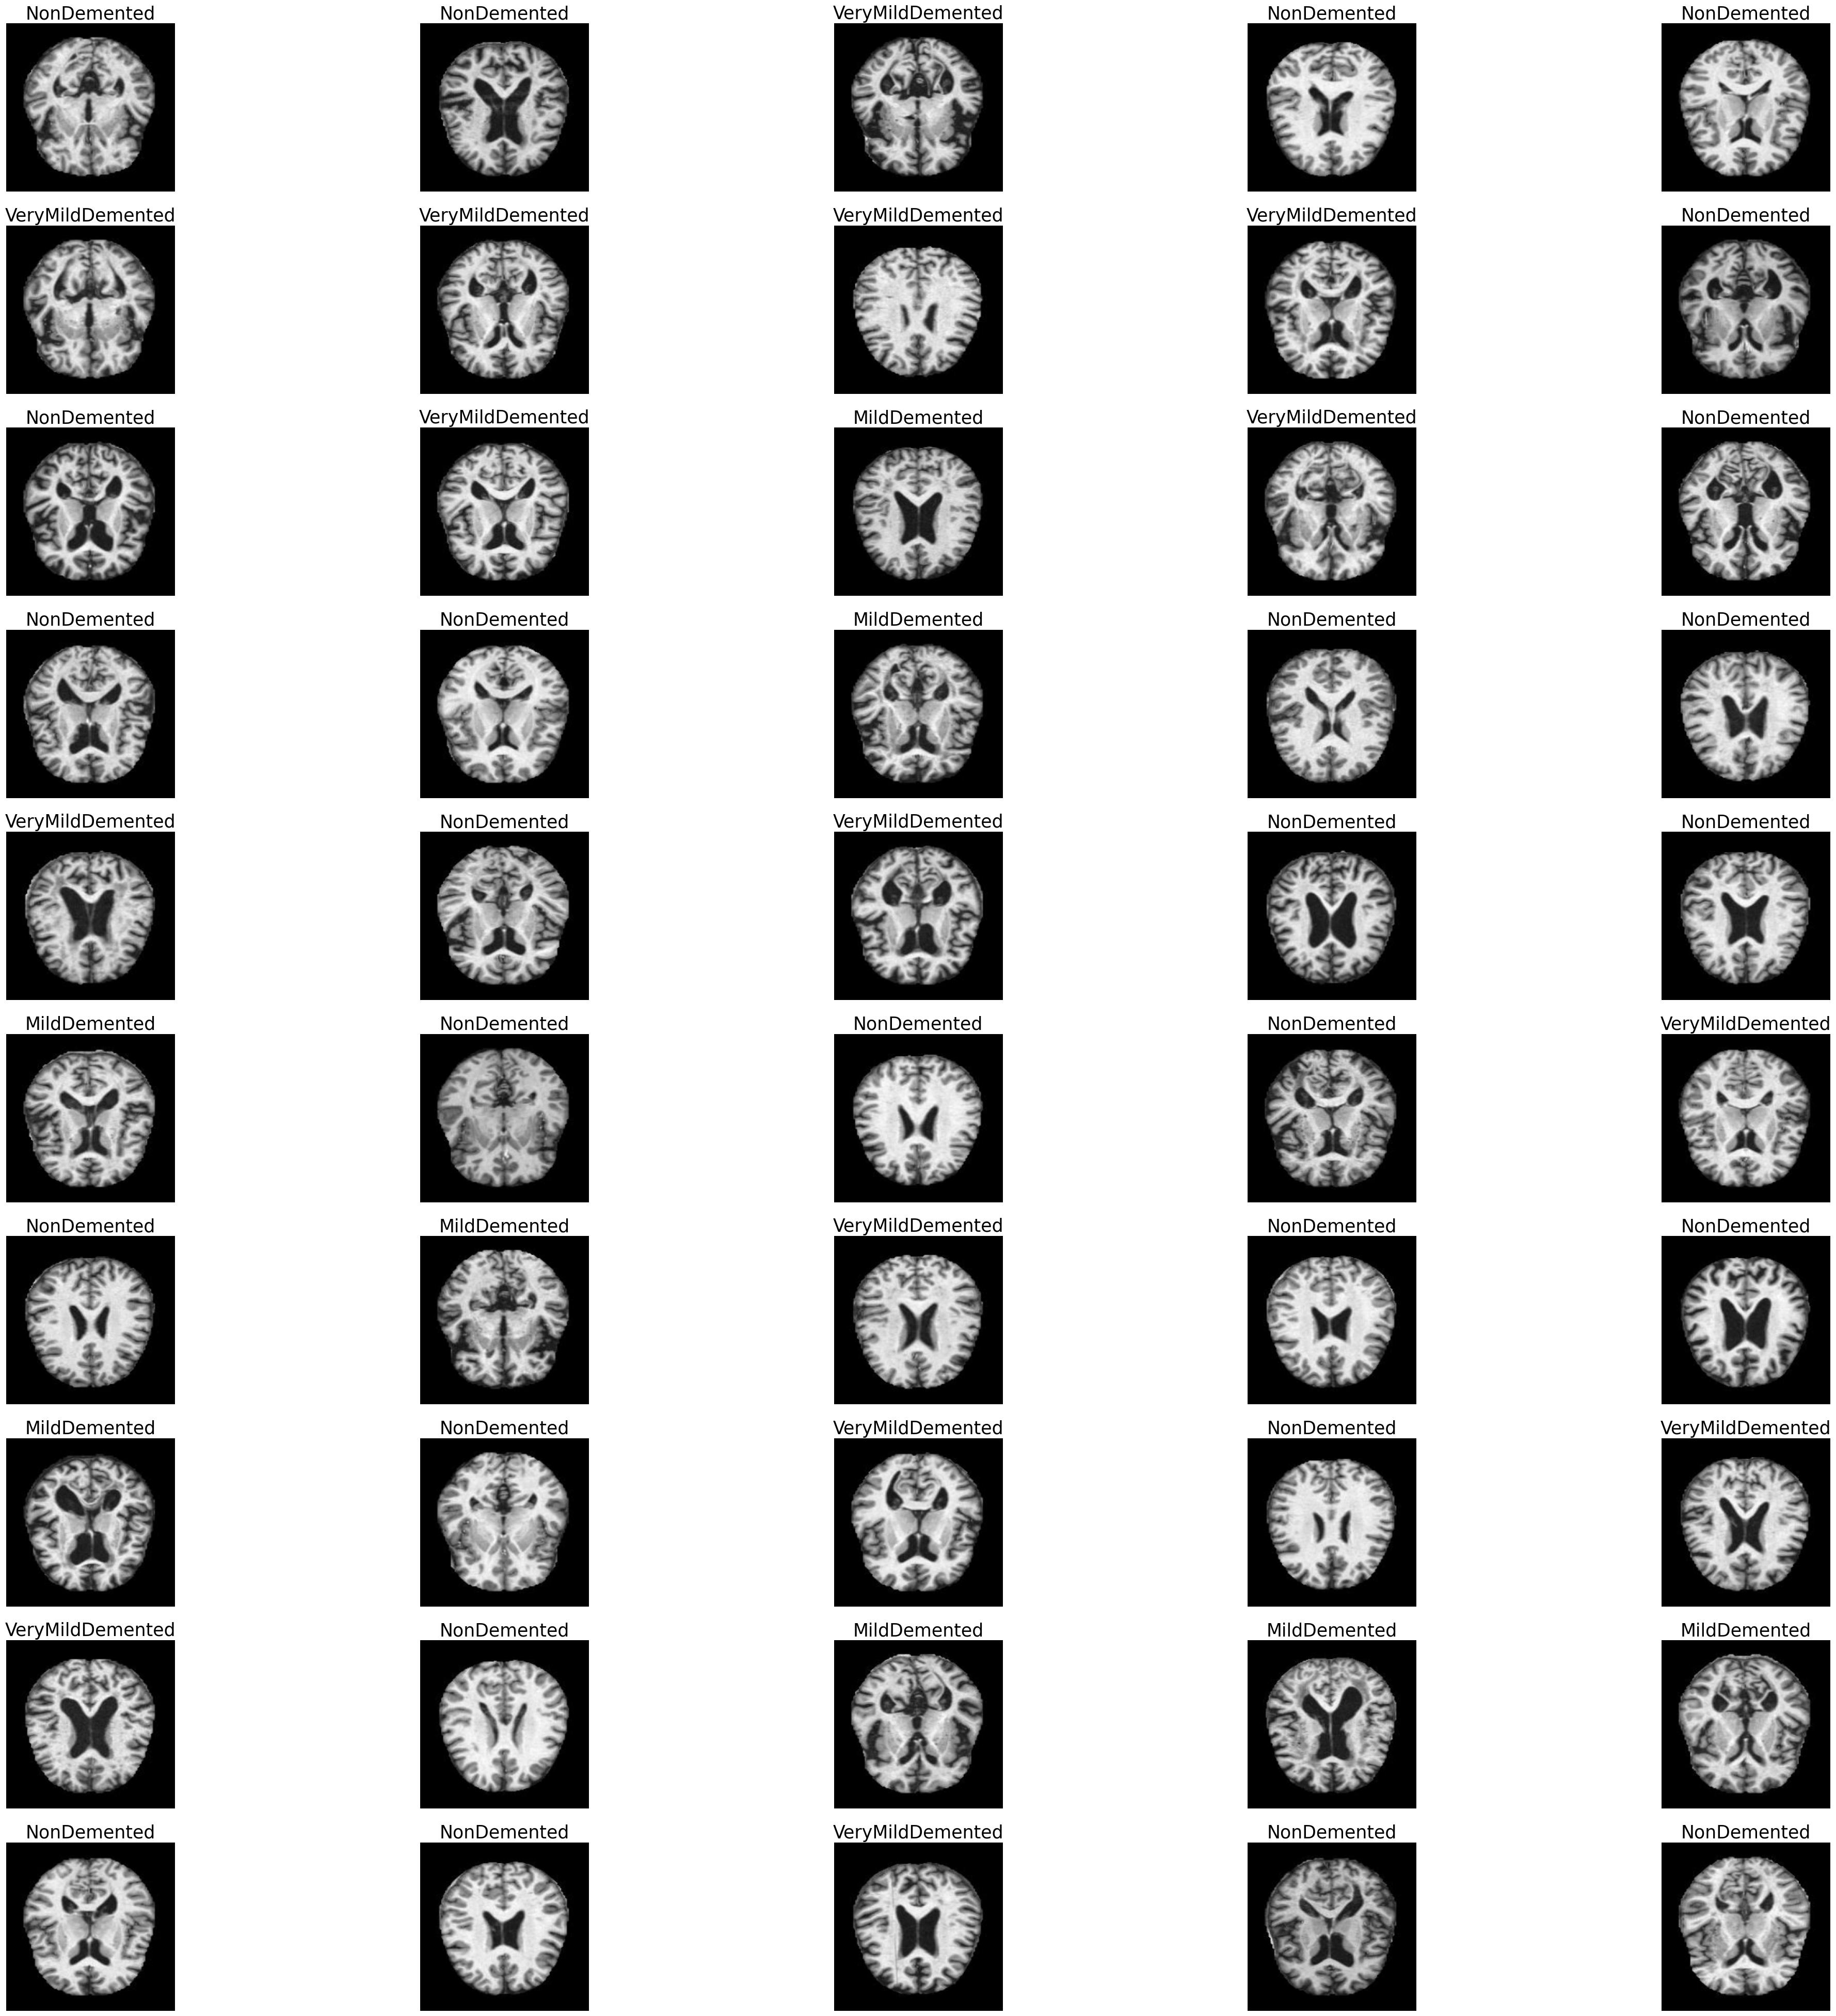

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Исследование данных</p>
<a class="btn" href="#home">Содержание</a>

In [ ]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [ ]:
train_data, train_labels = train_data_gen.next()

In [ ]:
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

In [ ]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


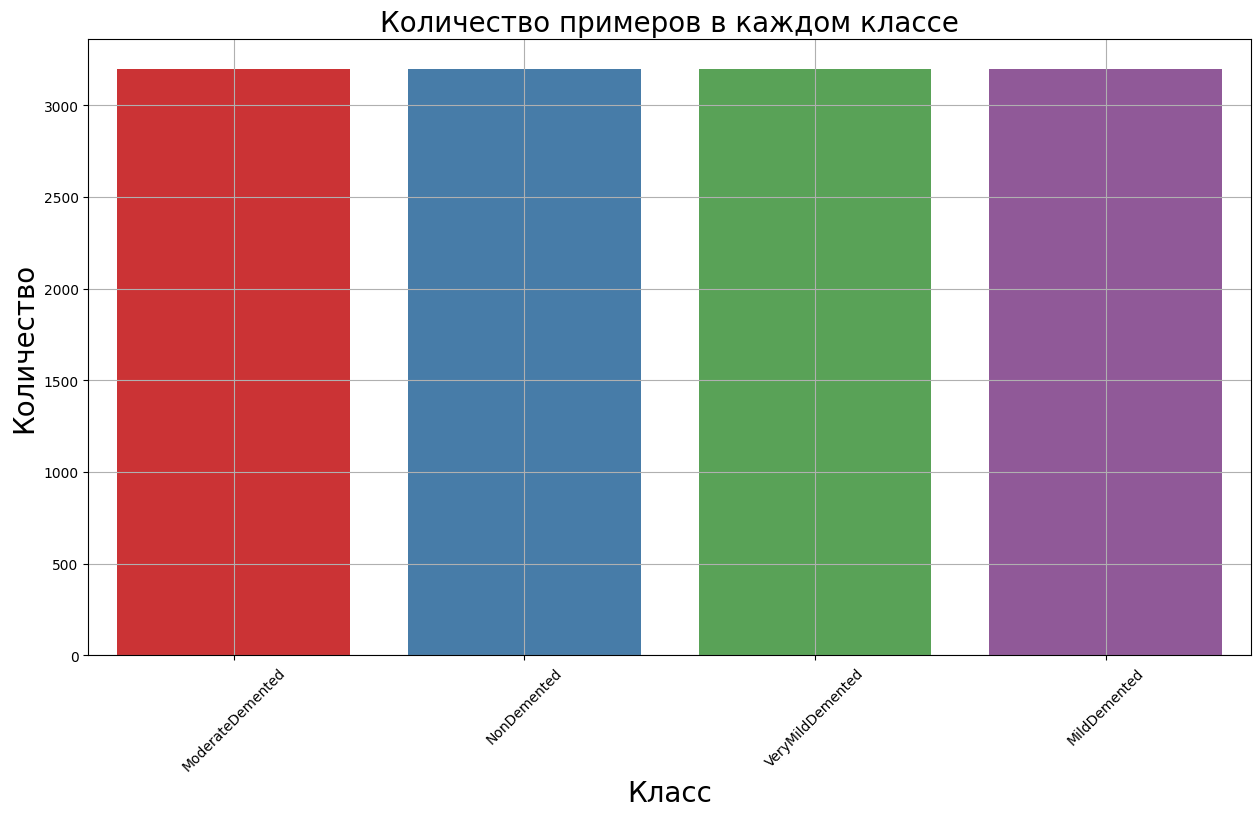

In [ ]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Класс",fontsize=20)
ax.set_ylabel("Количество",fontsize=20)
plt.title('Количество примеров в каждом классе',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train форма ' , X_train.shape)
print('X_test форма ' , X_test.shape)
print('X_val форма ' , X_val.shape)
print('y_train форма ' , y_train.shape)
print('y_test форма ' , y_test.shape)
print('y_val форма ' , y_val.shape)

X_train форма  (4480, 176, 176, 3)
X_test форма  (960, 176, 176, 3)
X_val форма  (960, 176, 176, 3)
y_train форма  (4480, 4)
y_test форма  (960, 4)
y_val форма  (960, 4)


<a id="10"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">InceptionV3 Модель </p>
<a class="btn" href="#home">Содержание</a>

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=(176,176,3),include_top=False,weights='imagenet')
base_model.trainable = False
model_Inception=keras.models.Sequential()
model_Inception.add(base_model)
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.GlobalAveragePooling2D())
model_Inception.add(keras.layers.Flatten())
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dense(512,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(256,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(128,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(64,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dense(4, activation=tf.nn.softmax))
model_Inception.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                         

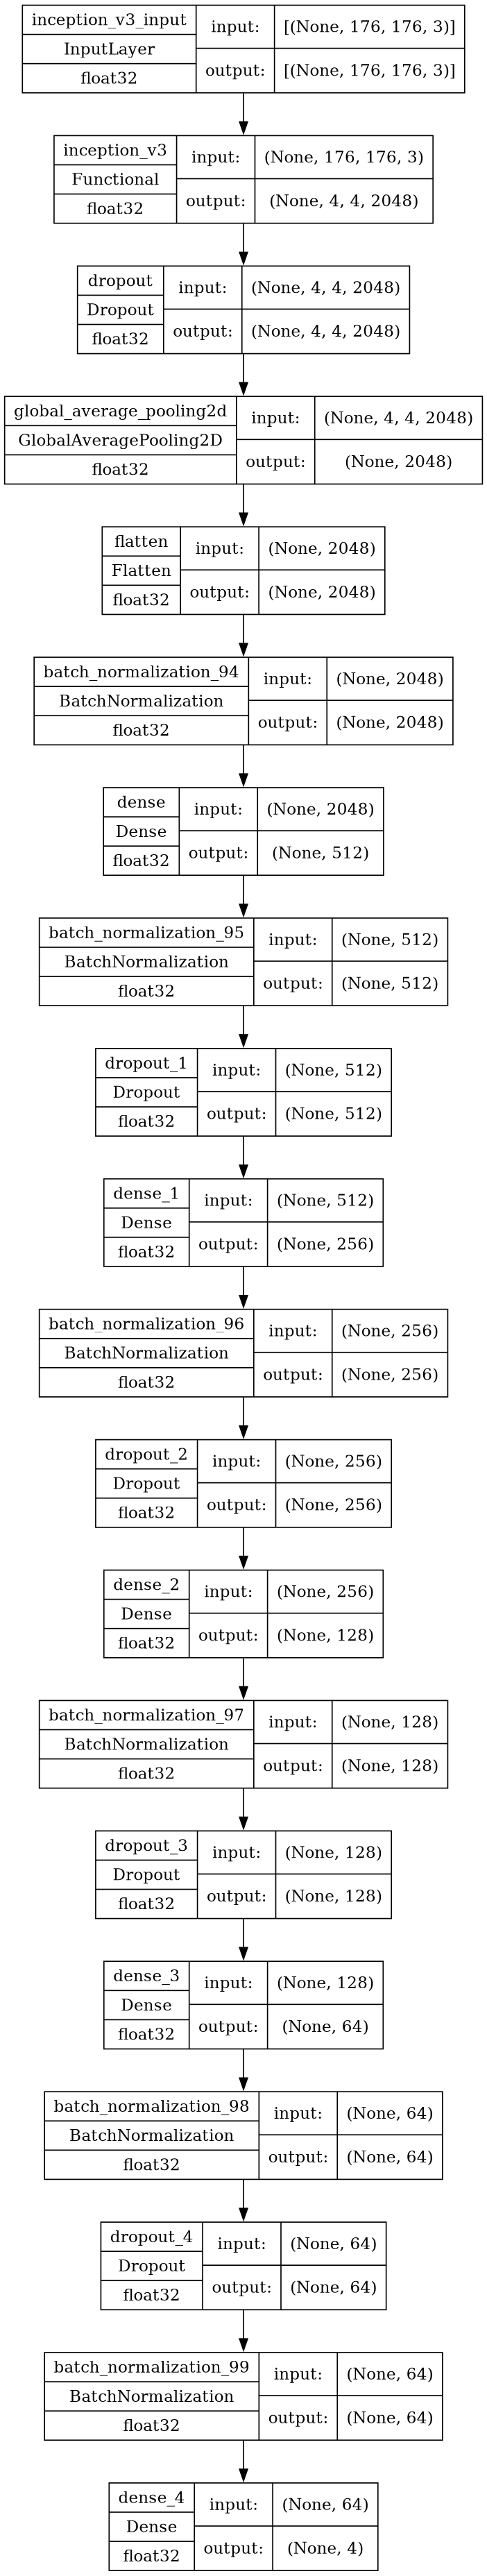

In [ ]:
tf.keras.utils.plot_model(model_Inception, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
checkpoint_cb =ModelCheckpoint("model_Inception.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model_Inception.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model_Inception.fit(X_train,y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
140/140 [==============================] - ETA: 0s - loss: 1.5242 - accuracy: 0.3725

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 379s 3s/step - loss: 1.5242 - accuracy: 0.3725 - val_loss: 1.0063 - val_accuracy: 0.5667
Epoch 2/100
140/140 [==============================] - 388s 3s/step - loss: 1.1825 - accuracy: 0.4741 - val_loss: 0.9251 - val_accuracy: 0.5854
Epoch 3/100
140/140 [==============================] - 380s 3s/step - loss: 1.0410 - accuracy: 0.5290 - val_loss: 0.8795 - val_accuracy: 0.6042
Epoch 4/100
140/140 [==============================] - 380s 3s/step - loss: 0.9735 - accuracy: 0.5442 - val_loss: 0.8676 - val_accuracy: 0.6042
Epoch 5/100
140/140 [==============================] - 360s 3s/step - loss: 0.9280 - accuracy: 0.5612 - val_loss: 0.8341 - val_accuracy: 0.6365
Epoch 6/100
140/140 [==============================] - 360s 3s/step - loss: 0.8935 - accuracy: 0.5743 - val_loss: 0.8191 - val_accuracy: 0.6427
Epoch 7/100
140/140 [==============================] - 377s 3s/step - loss: 0.8697 - accuracy: 0.5960 - val_loss: 0.8081 - val_accuracy: 0.6531
Epoc

<a id="11"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Оценка модели</p>
<a class="btn" href="#home">Содержание</a>

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Потери при обучении')
plt.plot(hist_['val_loss'],label='Потери при валидации')
plt.title('Потери: Обучение и Валидация',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Точность при обучении')
plt.plot(hist_['val_accuracy'],label='Точность при валидации')
plt.title('Точность: Обучение и Валидация',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score, acc= model_Inception.evaluate(X_test,y_test)
print('Потери тестирование =', score)
print('Точность тестирования =', acc)

In [ ]:
predictions = model_Inception.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'реальные': y_test_, 'прогноз': y_pred})
df

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_test),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} >>> {class_num[y_pred[i]]}',fontsize=15)

In [ ]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Отчет по классификации: ', ClassificationReport )